In [ ]:
import gzip
import json
from config import *

# Read dataset from the file
f = gzip.open(DATASET_PATH, "r")
# Process the lines into a preliminary dictionary
full_dataset = [json.loads(line) for line in f.readlines()]
f.close()

# -------------------------------
# amazon data processing
from amazon_processing import clean_dataset

# process the data (lemmatize, feature generation)
features, labels = clean_dataset(full_dataset, 5000)

In [14]:
import gzip
import json
import pickle
import importlib
import config
importlib.reload(config)
from config import *
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from autocorrect import Speller

import time
start = time.time()

spell = Speller(lang='en')

# Read dataset from the file
f = gzip.open(BIGRAM_DATASET_PATH, "r")
# Process the lines into a preliminary dictionary
body = f.read().decode('utf8')
lines = body.splitlines()
f.close()

depth = len(lines)

raw = [{}]*len(lines)
for i in range(1, min(depth, len(lines))):
    bigrams = lines[i].split(" ")
    raw[i] = {}
    for bigram in bigrams:
            try:
                colon = bigram.index(":")
                key = bigram[:colon]
                words = key.split("_")
                key = "_".join([spell(word) for word in words])
                if not any(str.isdigit(c) for c in key):
                    raw[i][key] = bigram[colon + 1:]
            except:
                continue
labels = []
lineDicts = []
for line in raw:
    try:
        labels.append(float(line["#label#"]))
        del line["#label#"]
        lineDicts.append(line)
    except KeyError:
        continue

lineStrings = []
for i in range(0, len(lineDicts)):
    linestr = ""
    for key, value in lineDicts[i].items():
        linestr += ((key + " ")*int(value))
    lineStrings.append(linestr)

tfidf_vectorizer = TfidfVectorizer()
bag_of_words = tfidf_vectorizer.fit_transform(lineStrings)
feature_names = tfidf_vectorizer.get_feature_names()

f = open(FEATURE_PATH, "wb")
pickle.dump(bag_of_words, f)
f.close()
f = open(FEATURE_NAMES, "w")
f.write(json.dumps(feature_names))
f.close()

# Converting the sparse matrix to dense runs out of memory
# features = pd.DataFrame(bag_of_words.toarray(), columns = feature_names)

print("FEATURE GENERATION TIME (depth=", depth, "): ", time.time() - start, "s", sep='')

C:\Users\Emmet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


FEATURE GENERATION TIME (depth=43339): 23912.805352211s


In [15]:
f = open(FEATURE_PATH, "rb")
X = pickle.load(f)
f.close()
y = labels

In [19]:
import config
importlib.reload(config)
from config import *

f = open(LABELS, "w")
f.write(json.dumps(labels))
f.close()

In [ ]:
import matplotlib.pyplot as plt 
# Visualize the ratings distribution
plt.hist(labels, density=True, bins=10)
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.show()

In [ ]:
# Feature array
print(features.head())

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import importlib
import config
import matplotlib.pyplot as plt
importlib.reload(config)
from config import PALETTE

def visualize_confusion_matrix(confusion):
    sns.heatmap(confusion, annot = True, cmap=PALETTE, fmt="g")
    plt.xlim(0, 4)
    plt.ylim(4, 0)
    plt.xlabel("Predicted Class")
    plt.ylabel("True class")
    plt.show()

NameError: name 'plt' is not defined

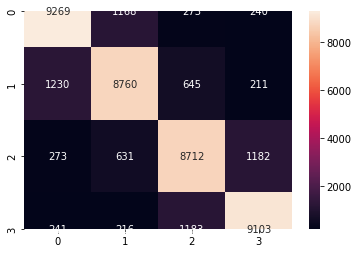

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

#y_pred = cross_val_predict(SVC(class_weight="balanced", C=0.05), X, y, cv = 5)
y_pred = cross_val_predict(SVC(), X, y, cv = 5)

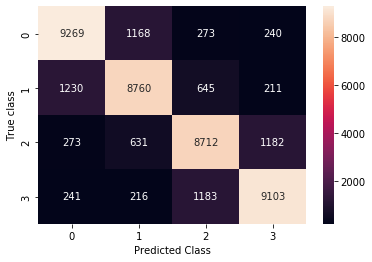

0.827099245448462


In [34]:
import config
importlib.reload(config)
from config import *

f = open(PREDICTIONS, "wb")
pickle.dump(y_pred, f)
f.close()

visualize_confusion_matrix(confusion_matrix(y, y_pred))
print(accuracy_score(y, y_pred))

In [35]:
import config
importlib.reload(config)
from config import *

svc = SVC()
svc.fit(X, y)

f = open(SVC_PATH, "wb")
pickle.dump(svc, f)
f.close()

f = open(TFID_PATH, "wb")
pickle.dump(tfidf_vectorizer, f)
f.close()

In [46]:
f = open(TFID_PATH, "rb")
tfid = pickle.load(f)
f.close()

f = open("example_review.txt", "r")
body = f.read()
f.close()

import pipeline
importlib.reload(pipeline)
from pipeline import digest
svc.predict(digest(body, tfid))

array([5.])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=3, weights="distance"), X, y, cv = 5)
visualize_confusion_matrix(confusion_matrix(y, y_pred))
print(accuracy_score(y, y_pred))

In [ ]:
from sklearn.naive_bayes import GaussianNB

y_pred = cross_val_predict(GaussianNB(), X, y, cv = 5)
visualize_confusion_matrix(confusion_matrix(y, y_pred))
print(accuracy_score(y, y_pred))